<a href="https://colab.research.google.com/github/busayojee/deeplearning/blob/main/FraudDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt




Data Engineering

In [ ]:
data = "creditcard.csv"
def split():
  dt = pd.read_csv(data, header=0)
  print(dt.head())
  dt.drop('Time', axis=1, inplace=True)
  print(dt.head())
  # print(dt.info())
  # # print(dt.isna().sum(axis=0))
  # # print(dt.isna().sum(axis=1))
  # # print(dt.isnull().sum())
  # dt = dt.sample(frac=1)
  print(dt.shape)

  # splitting into train test val
  train, test = train_test_split(dt, test_size=0.3)
  train.to_csv("train.csv")
  test.to_csv("test.csv")
  print(train.shape)
  print(test.shape)

split()

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

Loading the data into a dictionary


In [ ]:
def load_data():
  train = pd.read_csv("train.csv")
  test = pd.read_csv("test.csv")
  train = train.drop("Unnamed: 0", axis=1)
  test = test.drop("Unnamed: 0", axis=1)
  
  print(train.Class.value_counts())
  print(test.Class.value_counts())

  data = {}
  data["train_y"] = train.pop("Class")
  data["test_y"] = test.pop("Class")

  scaler = StandardScaler()
  train = scaler.fit_transform(train)
  test = scaler.transform(test)

  data["train_x"] = train
  data["test_x"] = test
  data["scaler"] = scaler
  print(data["scaler"])
  return data

data = load_data()
# print(data["scaler"])
# print(data["train_y"].shape)
# print(data["train_x"].shape)
# print(data["train_y"])




0    199024
1       340
Name: Class, dtype: int64
0    85291
1      152
Name: Class, dtype: int64
StandardScaler()


Building the Model

In [ ]:
from tensorflow.python import metrics
def model(input_features):
  # fraud7 with metrics Recall at precision
  input = tf.keras.layers.Input(shape=(input_features,))
  x = tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform', use_bias=True, kernel_regularizer = tf.keras.regularizers.l2(0.01))(input)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_uniform', use_bias=True,  kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
  model = tf.keras.Model(inputs =input, outputs=output)
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss = "binary_crossentropy", metrics = ["accuracy"])
  return model

m = model(29)

print(m.summary())




  

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 29)]              0         
                                                                 
 dense_6 (Dense)             (None, 128)               3840      
                                                                 
 batch_normalization_4 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_5 (Batc  (None, 64)               256       
 hNormalization)                                           

Training the model

In [ ]:
# Creating callback
def checkpoint():
  tensorboard = tf.keras.callbacks.TensorBoard(log_dir='logs1', write_graph = True, write_grads = False)
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, min_lr=0.0001)
  return [tensorboard, early_stopping, reduce_lr]

In [ ]:
# training the data
data = load_data()
input = data["train_x"].shape[1]
print(input)
models = model(input_features = input)
callbacks = checkpoint()
models.fit(x = data["train_x"], y = data["train_y"], batch_size = 64, epochs=30, verbose=1, validation_split = 0.2, callbacks = callbacks)
models.save("fraud4.h5")



In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs1

In [ ]:
model = tf.keras.models.load_model("fraud7.h5")
prediction = model.predict(data["test_x"])

2671/2671 [==============================] - 6s 2ms/step


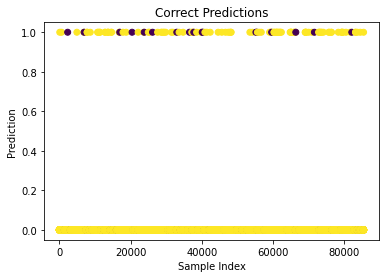

In [ ]:
df_ans = pd.DataFrame({'Real Class' :data["test_y"]})
df_ans['Prediction'] = prediction >0.5
df_ans[ df_ans['Real Class'] != df_ans['Prediction'] ]
# Convert predictions to binary labels (0 or 1)
predictions = prediction > 0.5

predictions = predictions.reshape(-1)
# Plot a graph to show the correct predictions
y_test = data["test_y"]
# Plot a graph to show the correct predictions
plt.scatter(range(len(predictions)), predictions, c=predictions == y_test)
plt.xlabel('Sample Index')
plt.ylabel('Prediction')
plt.title('Correct Predictions')
plt.show()

In [ ]:
df_ans['Prediction'].value_counts()

False    85323
True       120
Name: Prediction, dtype: int64

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plot the confusion matrix using seaborn heatmap
sns.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()
# fraud 7

Testing with single input instances from the test data

In [ ]:
test = pd.read_csv("test.csv")
test = test.drop("Unnamed: 0", axis=1)

test = test.iloc[469]
test_y = test.pop("Class")
input = test.values
print(input)
print(test_y)


[-2.74048250e+00  3.65809482e+00 -4.11063552e+00  5.34024167e+00
 -2.66677476e+00 -9.27818149e-02 -4.38869881e+00 -2.80132706e-01
 -2.82189458e+00 -4.46628416e+00  3.96979981e+00 -7.34671679e+00
 -1.16331177e+00 -8.22556891e+00  8.25001832e-01 -6.77286703e+00
 -8.81578543e+00 -4.56885928e+00  1.12659866e+00  1.85325270e-01
  2.41749541e+00 -9.77119509e-02  3.82154507e-01 -1.54756520e-01
 -4.03955926e-01  2.77894930e-01  8.30061639e-01  2.18690442e-01
  1.12330000e+02]
1.0


In [ ]:

scaler = data["scaler"]
print(test_y)
input = input.reshape(1,-1)
scaled = scaler.transform(input)
print(scaled.shape)

prediction = model.predict(scaled)
# print(predictions)
print(prediction)
if test_y == (prediction > 0.5):
    print("The prediction is correct.")
else:
    print("The prediction is incorrect.")

1.0
(1, 29)
1/1 [==============================] - 0s 14ms/step
[[1.]]
The prediction is correct.


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
xtest = data["test_x"]
ytest = data["test_y"]
scaler = data["scaler"]

xtest_inst = xtest[469:470]
ytest_int = ytest[469:470]
predictions = model.predict(xtest_inst)
print(ytest_int.values[0])
print(int(predictions))



1/1 [==============================] - 2s 2s/step
1
1


Hyperparameter Tuning Using random search (Run only once because of the time it takes)

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV

# # specify the hyperparameters and the possible values
# def create_model(optimizer='adam'):
#     model = tf.keras.Sequential()
#     model.add(tf.keras.layers.Dense(128, activation='relu', kernel_initializer='uniform', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
#     model.add(tf.keras.layers.Dropout(0.5))
#     model.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer='uniform', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
#     model.add(tf.keras.layers.Dropout(0.5))
#     model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
#     model.compile(optimizer=optimizer, loss = "binary_crossentropy", metrics = ["accuracy"])
#     return model

# param_grid = {'epochs': [10, 20, 30], 'batch_size': [32, 64, 128], 
#               'optimizer': ['Adam','RMSprop']}
# estimator = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model)
# grid = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid, n_iter=10, cv=3, n_jobs=-1)
# grid.fit(data["train_x"], data["train_y"])

In [ ]:
best_params = grid.best_params_
print(best_params)

{'optimizer': 'Adam', 'epochs': 30, 'batch_size': 64}


Deploying the model using FLASK API

In [ ]:
!pip install --upgrade flask-ngrok

In [ ]:
from flask import Flask, render_template, request
from flask_ngrok import run_with_ngrok
from pyngrok import ngrok

In [ ]:
 !pip install pyngrok

In [ ]:
!ngrok authtoken 1k9L5QgWAlcGov4IeWwaJBsc6gK_7RDCMELZb76jKjMw6y17o

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
!ngrok http 5000 --host-header rewrite

In [ ]:
app = Flask(__name__)
# ngrok.connect(host="127.0.0.1:5000", auth_token="1k9L5QgWAlcGov4IeWwaJBsc6gK_7RDCMELZb76jKjMw6y17o")
run_with_ngrok(app)
# load your model
model = tf.keras.models.load_model("fraud4.h5")
scaler = data["scaler"]
@app.route('/')
def form():
    return render_template('form.html')
    # return "Hello"

@app.route('/predict', methods=['POST'])
def predict():
    # get the input values from the form
    input_values = [request.form[str(i)] for i in range(1,30)]
    
    # convert the input values to a numpy array
    input_values = np.array(input_values).reshape(1, -1)
    input_values = scaler.transform(input_values)
    # make a prediction
    prediction = model.predict(input_values)
    
    # return the prediction
    return str(prediction[0][0])

# if __name__ == '__main__':
    # app.run(debug=True, port=80)

app.run()